In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import time
import torch
import pathlib
import numpy as np
import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt

def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title='', colour_map=plt.cm.OrRd):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=colour_map)
    plt.tight_layout()
    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

def find_active_weights_heads(masks, layer, head):
    
    start = head * 64
    end = (head + 1) * 64
    active = 0
    total = 0
    
    for component in ["key", "query", "value"]:

        weight_key = f"bert.encoder.layer.{layer}.attention.self.{component}.weight_mask"
        bias_key =  f"bert.encoder.layer.{layer}.attention.self.{component}.bias_mask"
        active += masks[weight_key][start:end].sum() + masks[bias_key][start:end].sum()
        total +=  masks[weight_key][start:end].numel() + masks[bias_key][start:end].numel()
    output_weight_key = f"bert.encoder.layer.{layer}.attention.output.dense.weight_mask"
    output_bias_key = f"bert.encoder.layer.{layer}.attention.output.dense.bias_mask"
    active += masks[output_weight_key][:,start:end].sum() +  masks[output_bias_key][start:end].sum()
    total += masks[output_weight_key][:,start:end].numel() +  masks[output_bias_key][start:end].numel()
    
    return active / total

def find_active_weights_mlps(masks, layer):
    
    active = 0
    total = 0
    weight_key = f"bert.encoder.layer.{layer}.intermediate.dense.weight_mask"
    bias_key =  f"bert.encoder.layer.{layer}.intermediate.dense.bias_mask"
    active += masks[weight_key].sum() + masks[bias_key].sum()
    total +=  masks[weight_key].numel() + masks[bias_key].numel()
    weight_key = f"bert.encoder.layer.{layer}.output.dense.weight_mask"
    bias_key =  f"bert.encoder.layer.{layer}.output.dense.bias_mask"
    active += masks[weight_key].sum() + masks[bias_key].sum()
    total +=  masks[weight_key].numel() + masks[bias_key].numel()
    
    return active / total


def load_mask_data(experiments_path):
    mask_data = {}
    for task_dir in experiments_path.iterdir():
        mask_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mask = torch.load(seed_dir / "magnitude_mask.p")
            mask_data[task_dir.stem][seed_dir.stem] = mask
    return mask_data
def average_surviving_weights(task, masks):
    surviving_heads = {}
    total = 0
    active = 0
    for seed in masks[task]:
        active += sum([v.sum() for _, v in  masks[task][seed].items()])
        total += sum([v.numel() for _, v in  masks[task][seed].items()])
    return (active/total).item()

In [3]:
exp = pathlib.Path("../masks/global/")
masks = load_mask_data(exp)

WNLI
Average surviving weights across seeds: 0.4757007956504822
HEAD


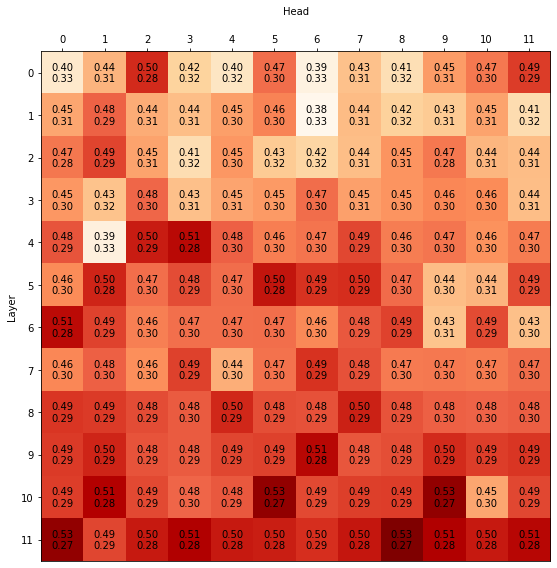

MLP


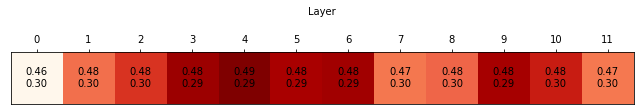

MRPC
Average surviving weights across seeds: 0.5645498633384705
HEAD


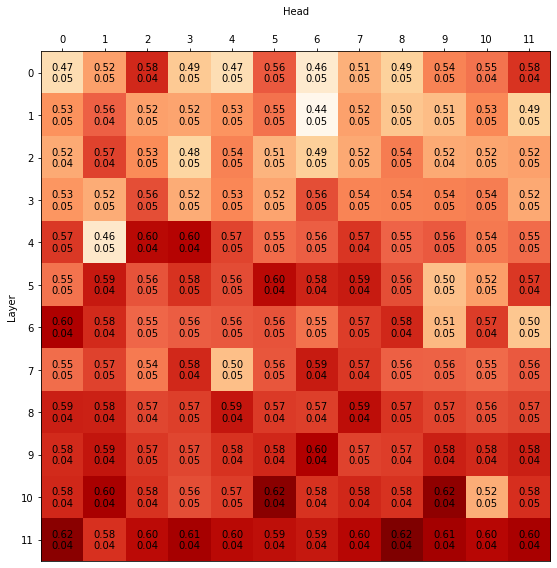

MLP


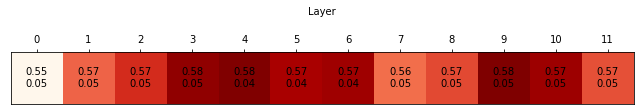

MNLI
Average surviving weights across seeds: 0.513342022895813
HEAD


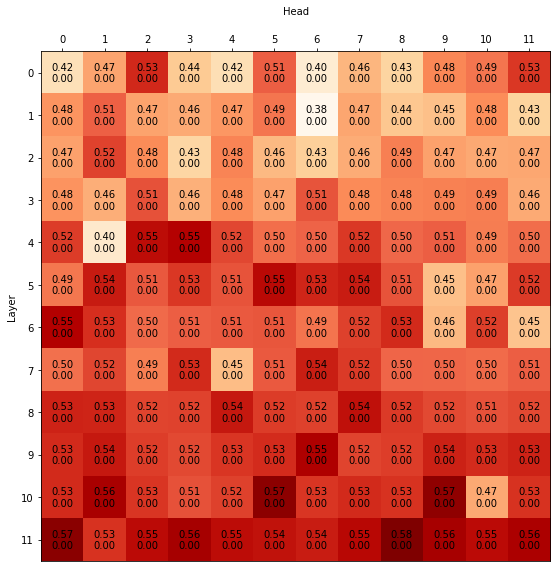

MLP


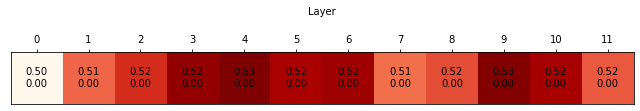

QQP
Average surviving weights across seeds: 0.4779214859008789
HEAD


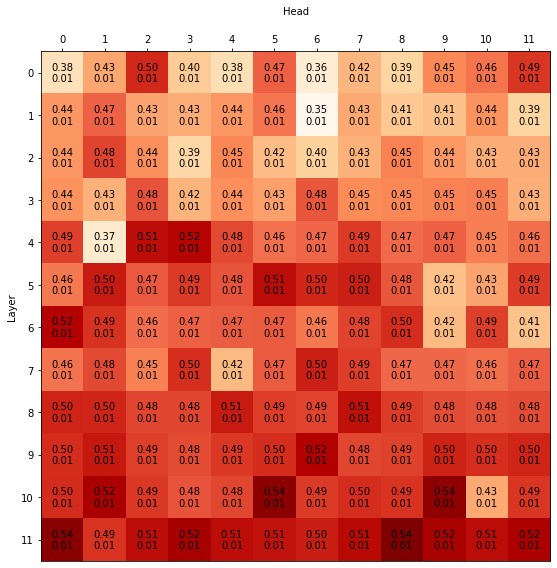

MLP


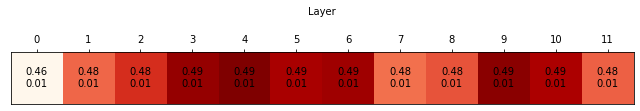

RTE
Average surviving weights across seeds: 0.5301074385643005
HEAD


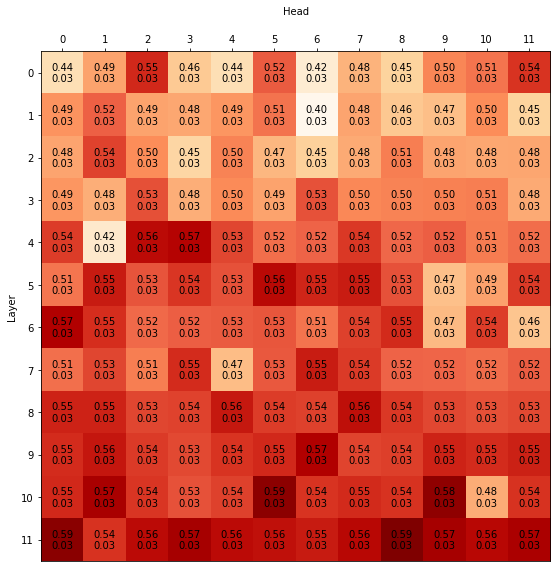

MLP


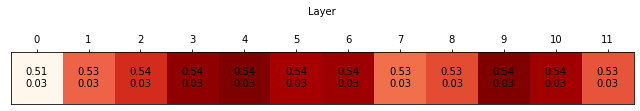

SST-2
Average surviving weights across seeds: 0.4357253909111023
HEAD


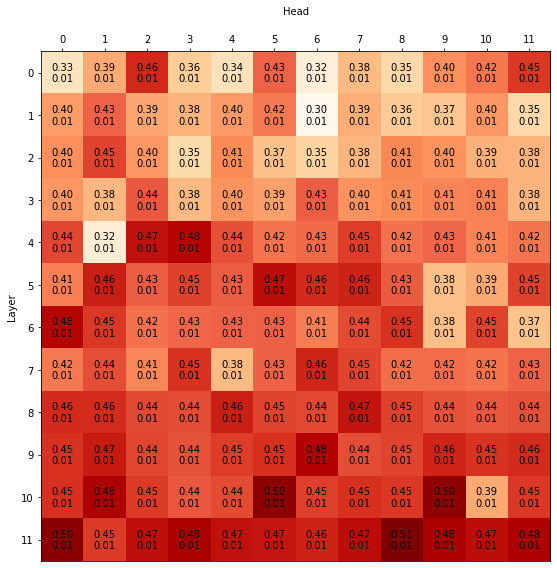

MLP


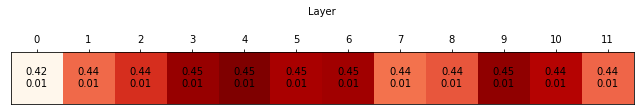

STS-B
Average surviving weights across seeds: 0.5033454298973083
HEAD


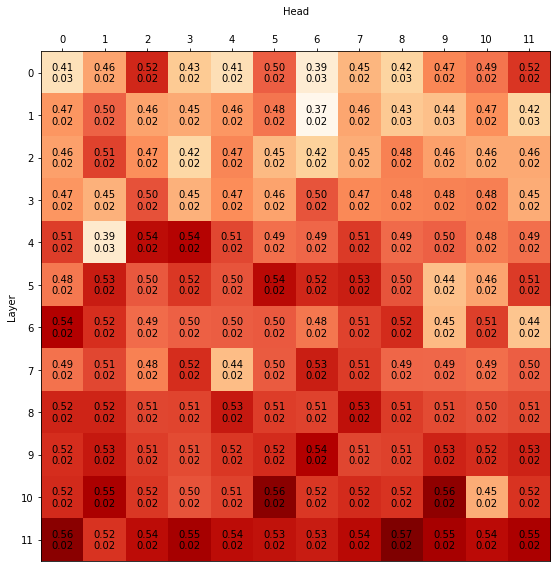

MLP


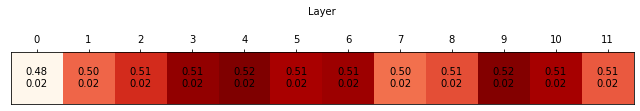

CoLA
Average surviving weights across seeds: 0.6355140209197998
HEAD


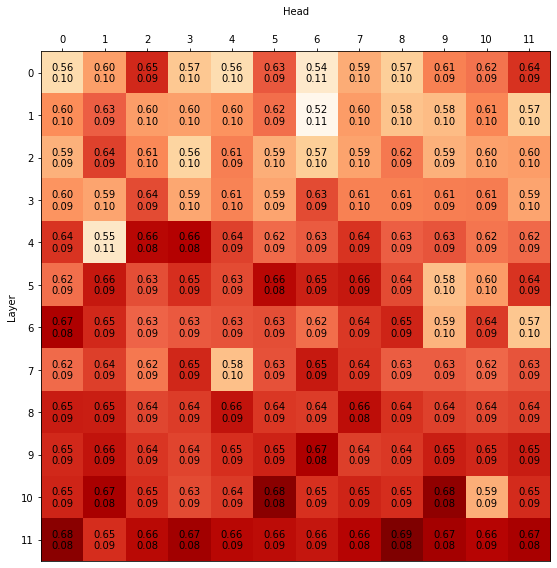

MLP


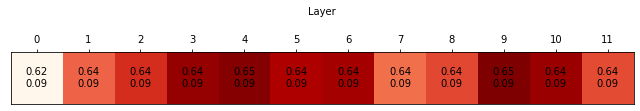

QNLI
Average surviving weights across seeds: 0.5295528173446655
HEAD


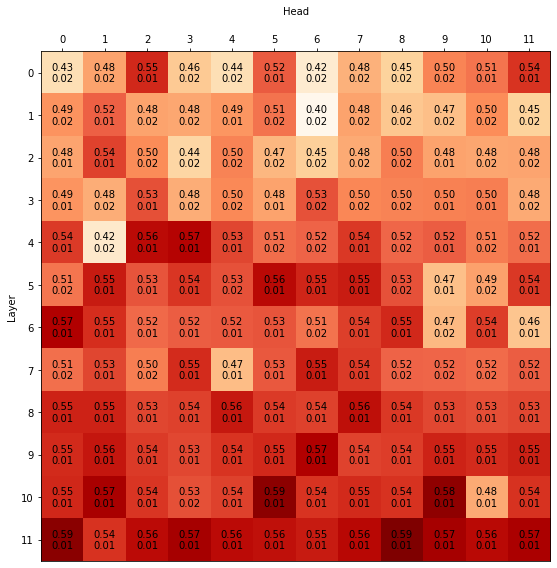

MLP


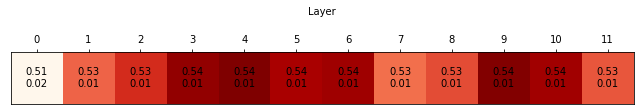

In [4]:
def task_wise_head_heatmaps(masks):
    for task in masks:
        layer_v_head = np.zeros((5, 12, 12))
        mlps = np.zeros((5,1, 12))
        print(task)
        print("Average surviving weights across seeds:", average_surviving_weights(task, masks))
        for seed_idx, seed in enumerate(masks[task]):
            mask =  masks[task][seed]
            for layer in range(12):
                mlps[seed_idx][0][layer] = find_active_weights_mlps(mask, layer)
                for head in range(12):
                    layer_v_head[seed_idx][layer][head] = find_active_weights_heads(mask, layer, head)
        mean_head = np.mean(layer_v_head, axis=0)
        std_head = np.std(layer_v_head, axis=0, ddof=1)
        print("HEAD")
        plot_matrix(mean_head, std_head, list(map(str, range(12))), list(map(str, range(12))), None, "Head", "Layer")
        mean_mlp = np.mean(mlps, axis=0)
        std_mlp = np.std(mlps, axis=0, ddof=1)
        print("MLP")
        plot_matrix(mean_mlp, std_mlp, list(map(str, range(12))), [], None, "Layer", "")

        
task_wise_head_heatmaps(masks)